$\Large \text{Testing 1/4 degree simulation}$ 

The test run was forced with analytical wind stress, surface heat flux and freshwater forcing. Sponge was used in 2 deg region to restore temperature and salinity near the northern boundary. The run used EOS from Wright et al. (1997). 

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
from xgcm import Grid
import dask 
import dask.distributed
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:43259 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 16 Memory: 406.01 GB


$\large \text{Stats time series}$

In [3]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/Z_star/TS_Wright/Res_025/"
ds_stat = xr.open_mfdataset(ppdir+"ocean.stats*.nc")
print(ds_stat)

ds_n = xr.open_mfdataset(ppdir+"prog_n*.nc",decode_times=False)
dsgrid = xr.open_dataset(ppdir+"grid.nc", decode_times=False)
dsgrid = dsgrid.drop('Time')

ds_n = xr.merge([ds_n, dsgrid])
print(ds_n)

<xarray.Dataset>
Dimensions:        (Interface: 76, Layer: 75, Time: 1802)
Coordinates:
  * Layer          (Layer) float64 0.5 2.393 6.02 ... 3.848e+03 3.949e+03
  * Interface      (Interface) float64 0.0 1.0 3.787 ... 3.898e+03 4e+03
  * Time           (Time) timedelta64[ns] 0 days 10 days ... 18000 days
Data variables:
    Ntrunc         (Time) float64 dask.array<chunksize=(361,), meta=np.ndarray>
    En             (Time) float64 dask.array<chunksize=(361,), meta=np.ndarray>
    APE            (Time, Interface) float64 dask.array<chunksize=(361, 76), meta=np.ndarray>
    KE             (Time, Layer) float64 dask.array<chunksize=(361, 75), meta=np.ndarray>
    H0             (Time, Interface) float64 dask.array<chunksize=(361, 76), meta=np.ndarray>
    Mass_lay       (Time, Layer) float64 dask.array<chunksize=(361, 75), meta=np.ndarray>
    Mass           (Time) float64 dask.array<chunksize=(361,), meta=np.ndarray>
    Mass_chg       (Time) float64 dask.array<chunksize=(361,), meta=n

Text(0, 0.5, 'Domain Mean Salinity (psu)')

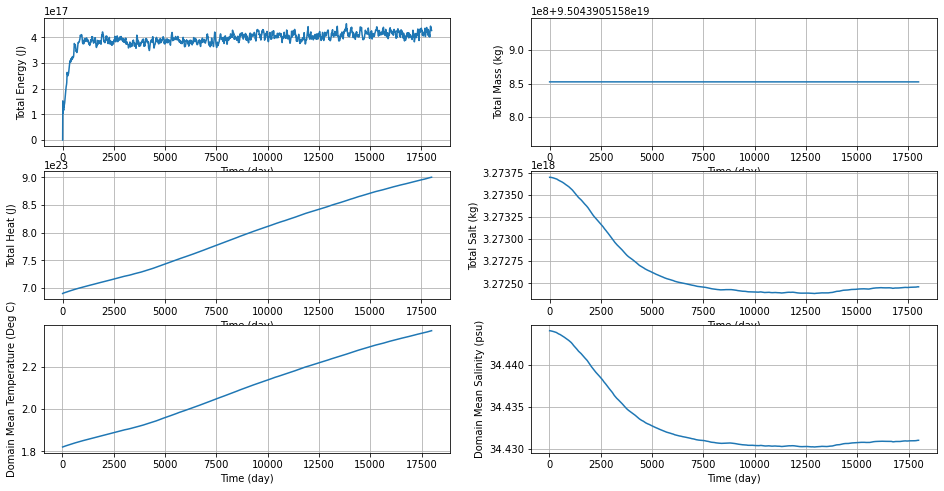

In [4]:
plt.figure(figsize=(16,8))

plt.subplot(3,2,1)
plt.plot(ds_stat['Time']/(24*3600*1e9), ds_stat['En'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Total Energy (J)')

plt.subplot(3,2,2)
plt.plot(ds_stat['Time']/(1e9*3600*24), ds_stat['Mass'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Total Mass (kg)')

plt.subplot(3,2,3)
plt.plot(ds_stat['Time']/(1e9*3600*24), ds_stat['Heat'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Total Heat (J)')

plt.subplot(3,2,4)
plt.plot(ds_stat['Time']/(1e9*3600*24), ds_stat['Salt'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Total Salt (kg)')

plt.subplot(3,2,5)
plt.plot(ds_n['Time'], ds_n['thetaoga'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Domain Mean Temperature (Deg C)')

plt.subplot(3,2,6)
plt.plot(ds_n['Time'], ds_n['soga'])
plt.grid()
plt.xlabel('Time (day)')
plt.ylabel('Domain Mean Salinity (psu)')

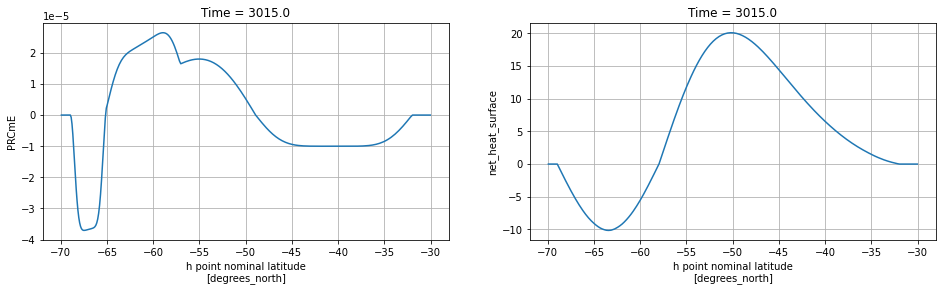

In [5]:
plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
ds_n['PRCmE'].isel(Time=100).mean('xh').plot()
plt.grid()

plt.subplot(1,2,2)
ds_n['net_heat_surface'].isel(Time=100).mean('xh').plot()
plt.grid()

In [6]:
ds_n.close()
ds_stat.close()

$\large \text{Spatial fields}$

In [7]:
ds_z = xr.open_mfdataset(ppdir+"prog_z*.nc",decode_times=False)
print(ds_z)

#ds_rho = xr.open_mfdataset(ppdir+"prog_rho2*.nc",decode_times=False)
#print(ds_rho)

<xarray.Dataset>
Dimensions:     (Time: 50, nv: 2, xh: 320, xq: 320, yh: 272, yq: 272, z_i: 36, z_l: 35)
Coordinates:
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 79.12 79.38 79.62 79.88
  * yh          (yh) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * z_l         (z_l) float64 0.5 3.019 9.006 ... 3.366e+03 3.613e+03 3.869e+03
  * z_i         (z_i) float64 0.0 1.0 5.038 12.97 ... 3.487e+03 3.738e+03 4e+03
  * Time        (Time) float64 180.0 540.0 900.0 ... 1.746e+04 1.782e+04
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 0.25 0.5 0.75 1.0 1.25 ... 79.25 79.5 79.75 80.0
  * yq          (yq) float64 -69.89 -69.81 -69.72 ... -30.35 -30.13 -29.92
Data variables:
    temp        (Time, z_l, yh, xh) float32 dask.array<chunksize=(10, 35, 272, 320), meta=np.ndarray>
    salt        (Time, z_l, yh, xh) float32 dask.array<chunksize=(10, 35, 272, 320), meta=np.ndarray>
    u           (Time, z_l, yh, xq) float32 dask.array<chunksize=(10, 35, 272, 320)

In [8]:
dsgrid = xr.open_dataset(ppdir+"grid.nc", decode_times=False)
dsgrid = dsgrid.drop('Time')

ds_z = xr.merge([ds_z, dsgrid])
#ds_rho = xr.merge([ds_rho, dsgrid])

In [19]:
grid = Grid(ds_z, coords={'X': {'center': 'xh', 'right': 'xq'},
                        'Y': {'center': 'yh', 'right': 'yq'},
                        'Z': {'center': 'z_l', 'outer': 'z_i'} }, periodic=['X']);

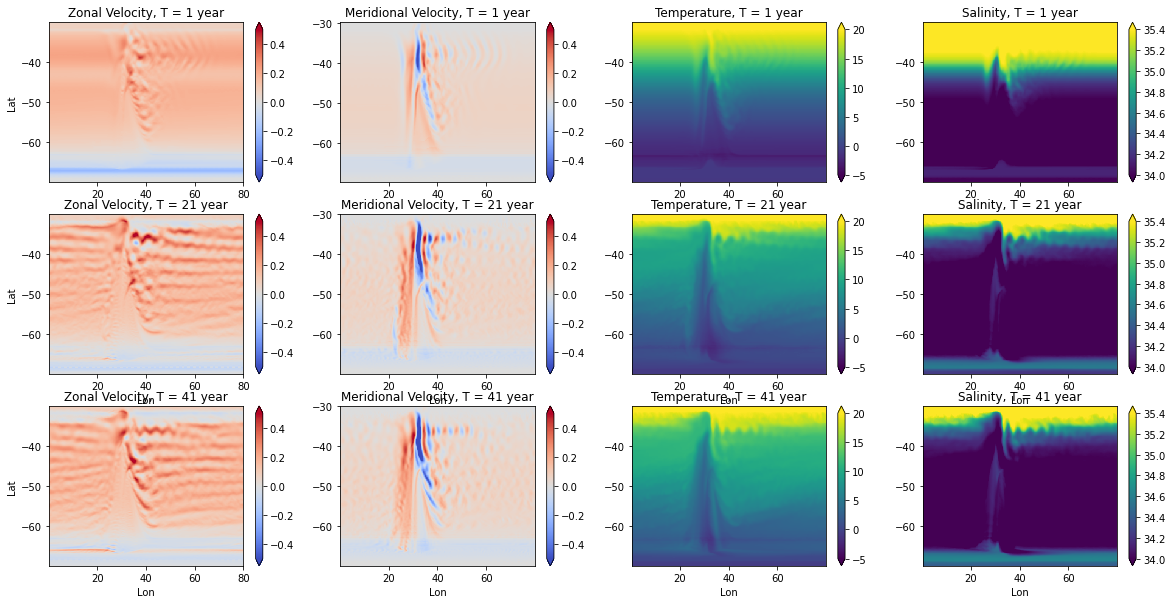

In [12]:
plt.figure(figsize=(20,10))

ct = 0
for i in range(0,50,20):
    plt.subplot(3,4,4*ct + 1)
    tmp = ds_z['u'].isel(Time = i, z_l=0)
    plt.pcolor(ds_z['xq'], ds_z['yh'], tmp, vmin = -0.5, vmax = 0.5, cmap='coolwarm')
    plt.colorbar(extend='both')
    plt.ylabel('Lat')
    if(ct>0):
        plt.xlabel('Lon')
    plt.title('Zonal Velocity, T = ' + str(i+1) + ' year')
    
    plt.subplot(3,4,4*ct + 2)
    tmp = ds_z['v'].isel(Time = i, z_l=0)
    plt.pcolor(ds_z['xh'], ds_z['yq'], tmp, vmin = -0.5, vmax = 0.5, cmap='coolwarm')
    plt.colorbar(extend='both')
    if(ct>0):
        plt.xlabel('Lon')
    plt.title('Meridional Velocity, T = ' + str(i + 1) + ' year')
    
    plt.subplot(3,4,4*ct + 3)
    tmp = ds_z['temp'].isel(Time = i, z_l=0)
    plt.pcolor(ds_z['xh'], ds_z['yh'], tmp, vmin = -5, vmax = 20.)
    plt.colorbar(extend='both')
    if(ct>0):
        plt.xlabel('Lon')
    plt.title('Temperature, T = ' + str(i+1) + ' year')
    
    plt.subplot(3,4,4*ct + 4)
    tmp = ds_z['salt'].isel(Time = i, z_l=0)
    plt.pcolor(ds_z['xh'], ds_z['yh'], tmp, vmin = 34., vmax = 35.4)
    plt.colorbar(extend='both')
    if(ct>0):
        plt.xlabel('Lon')
    plt.title('Salinity, T = ' + str(i+1) + ' year')
    
    ct = ct + 1

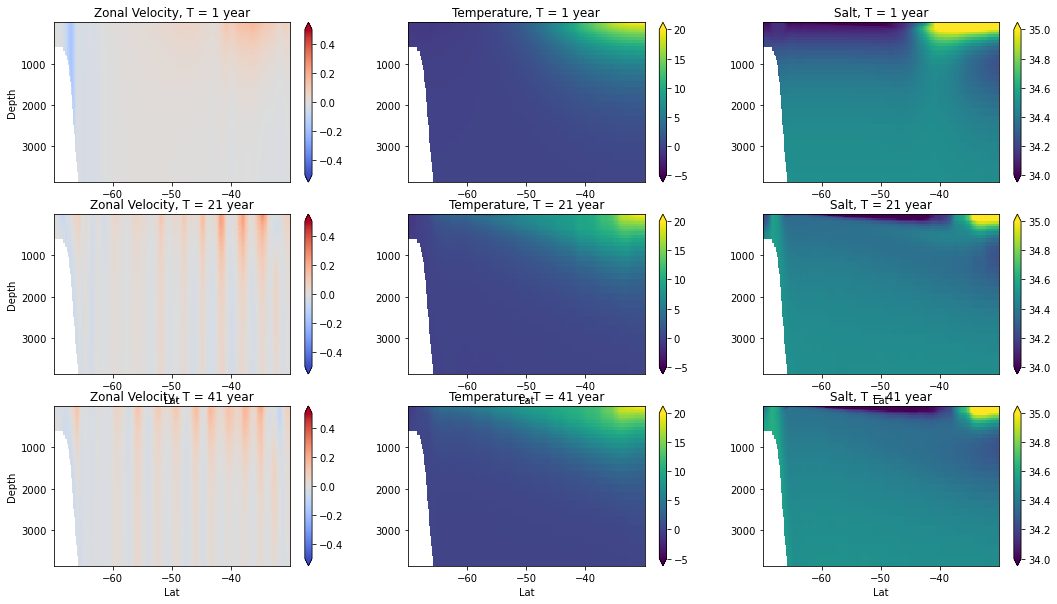

In [13]:
plt.figure(figsize=(18,10))

ct = 0
for i in range(0,50,20):
    plt.subplot(3,3,3*ct + 1)
    tmp = ds_z['u'].isel(Time = i, xq=240)
    plt.pcolor(ds_z['yh'], ds_z['z_l'], tmp, vmin = -0.5, vmax = 0.5, cmap='coolwarm')
    plt.colorbar(extend='both')
    plt.ylabel('Depth')
    if(ct>0):
        plt.xlabel('Lat')
    plt.title('Zonal Velocity, T = ' + str(i+1) + ' year')
    plt.gca().invert_yaxis()
    
    plt.subplot(3,3,3*ct + 2)
    tmp = ds_z['temp'].isel(Time = i, xh=240)
    plt.pcolor(ds_z['yh'], ds_z['z_l'], tmp, vmin = -5, vmax = 20.)
    plt.colorbar(extend='both')
    if(ct>0):
        plt.xlabel('Lat')
    plt.title('Temperature, T = ' + str(i+1) + ' year')
    plt.gca().invert_yaxis()
    
    plt.subplot(3,3,3*ct + 3)
    tmp = ds_z['salt'].isel(Time = i, xh=240)
    plt.pcolor(ds_z['yh'], ds_z['z_l'], tmp, vmin = 34.0, vmax = 35.0)
    plt.colorbar(extend='both')
    if(ct>0):
        plt.xlabel('Lat')
    plt.title('Salt, T = ' + str(i+1) + ' year')
    plt.gca().invert_yaxis()
    
    ct = ct + 1

Text(0.5, 1.0, '67 S')

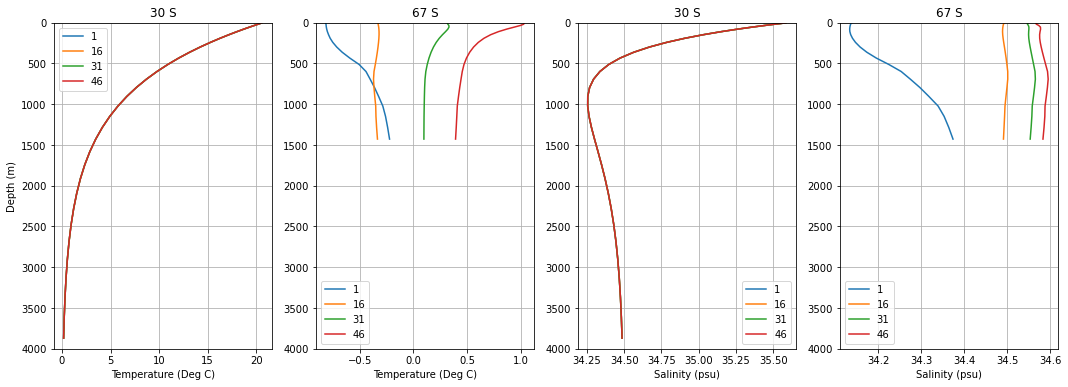

In [14]:
plt.figure(figsize=(18,6))

plt.subplot(1,4,1)
for i in range(0,50,15):
    tmp = ds_z['temp'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('30 S')

plt.subplot(1,4,2)
for i in range(0,50,15):
    tmp = ds_z['temp'].isel(Time=i).sel(yh=slice(-68.0, -67.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature (Deg C)')
plt.legend()
plt.title('67 S')

plt.subplot(1,4,3)
for i in range(0,50,15):
    tmp = ds_z['salt'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.title('30 S')
plt.legend()

plt.subplot(1,4,4)
for i in range(0,50,15):
    tmp = ds_z['salt'].isel(Time=i).sel(yh=slice(-68.0, -67.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.legend()
plt.title('67 S')

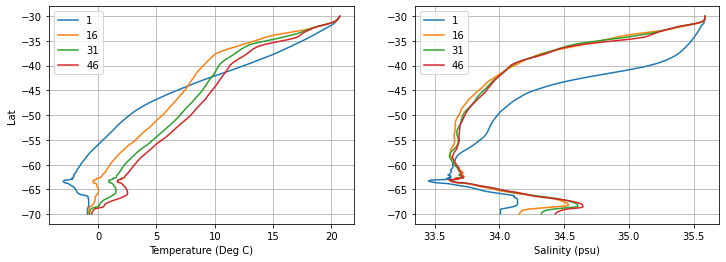

In [15]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for i in range(0,50,15):
    tmp = ds_z['temp'].isel(Time=i).isel(z_l=0).mean('xh')
    plt.plot(tmp, ds_z['yh'], label = str(i+1))
plt.grid()
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Lat')
plt.legend()

plt.subplot(1,2,2)
for i in range(0,50,15):
    tmp = ds_z['salt'].isel(Time=i).isel(z_l=0).mean('xh')
    plt.plot(tmp, ds_z['yh'], label = str(i+1))
plt.grid()
plt.xlabel('Salinity (psu)')
plt.legend()

$\large \text{Overturning Circulation}$

$$ \overline{v} = -\frac{\partial \overline{\psi}}{\partial z}$$

$$\frac{ \overline{vh}}{\overline{h}} = -\frac{\partial \psi^*}{\partial z}$$

$$\psi_{eddy} = \psi^* - \overline{\psi}$$


In [21]:
ds1 = ds_z.sel(xh=slice(50.,80.), xq =slice(50.,80.)).mean(['xh', 'xq'])
dz = grid.diff(ds1['z_i'], axis='Z')
#print(ds1)

#psi_m = ds['v'].cumsum

In [51]:
tmp = (ds1['v'] * dz * ds1['dxCv']).cumsum('z_l') 

psi_m = - (ds1['v'] * dz * ds1['dxCv'] + tmp - tmp.isel(z_l=34))

tmp = ds1['vmo'].cumsum('z_l')

psi = - (ds1['vmo'] + tmp  - tmp.isel(z_l=34))

psi = psi / 1035.

psi_e = psi - psi_m
                

In [50]:
#print(psi_m)
print(ds_z['vmo'])

<xarray.DataArray 'vmo' (Time: 50, z_l: 35, yq: 272, xh: 320)>
dask.array<concatenate, shape=(50, 35, 272, 320), dtype=float32, chunksize=(40, 35, 272, 320), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 0.125 0.375 0.625 0.875 ... 79.12 79.38 79.62 79.88
  * z_l      (z_l) float64 0.5 3.019 9.006 ... 3.366e+03 3.613e+03 3.869e+03
  * Time     (Time) float64 180.0 540.0 900.0 ... 1.71e+04 1.746e+04 1.782e+04
  * yq       (yq) float64 -69.89 -69.81 -69.72 -69.64 ... -30.35 -30.13 -29.92
Attributes:
    units:          kg s-1
    long_name:      Ocean Mass Y Transport
    cell_methods:   z_l:sum yq:point xh:sum time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  ocean_mass_y_transport
    interp_method:  none


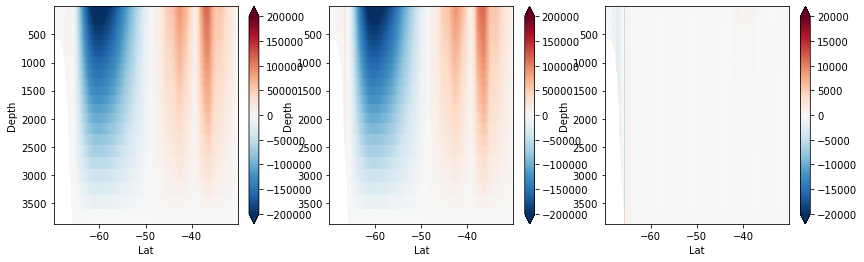

In [55]:
plt.figure(figsize=(14,4))

plt.subplot(1,3,1)
tmp = psi.isel(Time=0)
plt.pcolor(ds_z['yh'], ds_z['z_l'], tmp, vmin = -20e4, vmax = 20e4, cmap='RdBu_r')
plt.colorbar(extend='both')
plt.ylabel('Depth')
plt.xlabel('Lat')
plt.gca().invert_yaxis()

plt.subplot(1,3,2)
tmp = psi_m.isel(Time=0)
plt.pcolor(ds_z['yh'], ds_z['z_l'], tmp, vmin = -20e4, vmax = 20e4, cmap='RdBu_r')
plt.colorbar(extend='both')
plt.ylabel('Depth')
plt.xlabel('Lat')
plt.gca().invert_yaxis()

plt.subplot(1,3,3)
tmp = psi_e.isel(Time=0)
plt.pcolor(ds_z['yh'], ds_z['z_l'], tmp, vmin = -20e3, vmax = 20e3, cmap='RdBu_r')
plt.colorbar(extend='both')
plt.ylabel('Depth')
plt.xlabel('Lat')
plt.gca().invert_yaxis()

In [29]:
print(ds1)

<xarray.Dataset>
Dimensions:      (Time: 50, nv: 2, yh: 272, yq: 272, z_i: 36, z_l: 35)
Coordinates:
  * yh           (yh) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * z_l          (z_l) float64 0.5 3.019 9.006 ... 3.366e+03 3.613e+03 3.869e+03
  * z_i          (z_i) float64 0.0 1.0 5.038 12.97 ... 3.487e+03 3.738e+03 4e+03
  * Time         (Time) float64 180.0 540.0 900.0 ... 1.746e+04 1.782e+04
  * nv           (nv) float64 1.0 2.0
  * yq           (yq) float64 -69.89 -69.81 -69.72 ... -30.35 -30.13 -29.92
Data variables:
    temp         (Time, z_l, yh) float32 dask.array<chunksize=(10, 35, 272), meta=np.ndarray>
    salt         (Time, z_l, yh) float32 dask.array<chunksize=(10, 35, 272), meta=np.ndarray>
    u            (Time, z_l, yh) float32 dask.array<chunksize=(10, 35, 272), meta=np.ndarray>
    v            (Time, z_l, yq) float32 dask.array<chunksize=(10, 35, 272), meta=np.ndarray>
    umo          (Time, z_l, yh) float32 dask.array<chunksize=(10, 35, 272), meta

In [56]:
#ds_rho.close()
ds_z.close()
client.close()
cluster.close()

$\Large \text{Sponge Check}$

In [3]:
ppdir = "/work/Hemant.Khatri/MOM6_idealised/PEM_ACC/N_75/Z_star//TS_Wright/"
ds_z = xr.open_dataset(ppdir+"sponge_Matt/prog_z.nc",chunks={"Time": 1},decode_times=False)
#ds = xr.open_dataset(ppdir+"sponge_check/prog.nc",chunks={"Time": 1},decode_times=False)

In [4]:
print(ds_z)
#print(ds)

<xarray.Dataset>
Dimensions:     (Time: 5, nv: 2, xh: 320, xq: 320, yh: 272, yq: 272, z_i: 36, z_l: 35)
Coordinates:
  * xh          (xh) float64 0.125 0.375 0.625 0.875 ... 79.12 79.38 79.62 79.88
  * yh          (yh) float64 -69.94 -69.85 -69.77 ... -30.46 -30.24 -30.02
  * z_l         (z_l) float64 0.5 3.019 9.006 ... 3.366e+03 3.613e+03 3.869e+03
  * z_i         (z_i) float64 0.0 1.0 5.038 12.97 ... 3.487e+03 3.738e+03 4e+03
  * Time        (Time) float64 180.0 540.0 900.0 1.26e+03 1.62e+03
  * nv          (nv) float64 1.0 2.0
  * xq          (xq) float64 0.25 0.5 0.75 1.0 1.25 ... 79.25 79.5 79.75 80.0
  * yq          (yq) float64 -69.89 -69.81 -69.72 ... -30.35 -30.13 -29.92
Data variables:
    temp        (Time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 272, 320), meta=np.ndarray>
    salt        (Time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 272, 320), meta=np.ndarray>
    u           (Time, z_l, yh, xq) float32 dask.array<chunksize=(1, 35, 272, 320), meta=np.

Text(0.5, 1.0, '67 S')

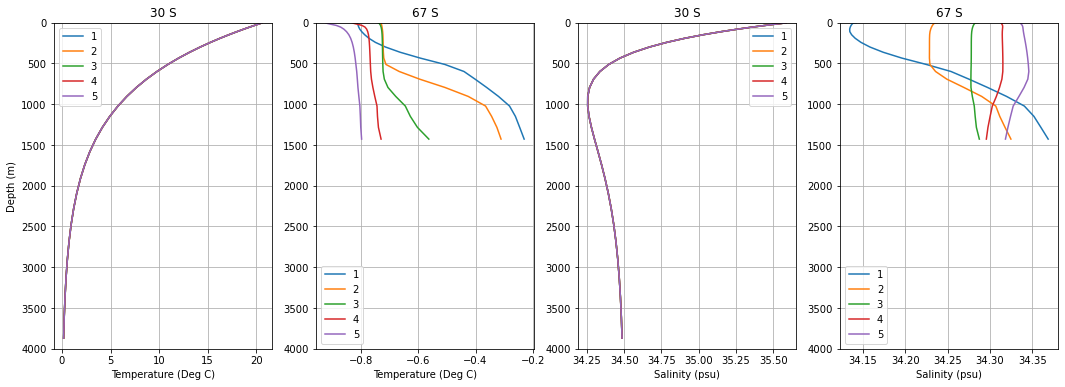

In [5]:
plt.figure(figsize=(18,6))

plt.subplot(1,4,1)
for i in range(0,5,1):
    tmp = ds_z['temp'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('30 S')

plt.subplot(1,4,2)
for i in range(0,5,1):
    tmp = ds_z['temp'].isel(Time=i).sel(yh=slice(-68.0, -67.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature (Deg C)')
plt.legend()
plt.title('67 S')

plt.subplot(1,4,3)
for i in range(0,5,1):
    tmp = ds_z['salt'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.title('30 S')
plt.legend()

plt.subplot(1,4,4)
for i in range(0,5,1):
    tmp = ds_z['salt'].isel(Time=i).sel(yh=slice(-68.0, -67.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1))
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.legend()
plt.title('67 S')

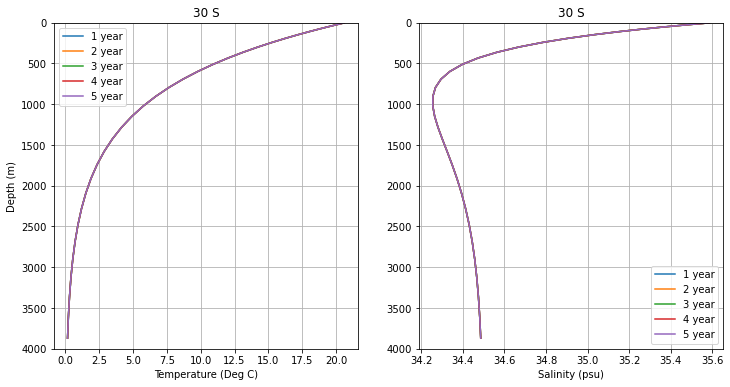

In [6]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
for i in range(0,5,1):
    tmp = ds_z['temp'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1) + ' year')
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Temperature (Deg C)')
plt.ylabel('Depth (m)')
plt.legend()
plt.title('30 S')

plt.subplot(1,2,2)
for i in range(0,5,1):
    tmp = ds_z['salt'].isel(Time=i).sel(yh=slice(-31.0, -30.0)).mean(['xh','yh'])
    plt.plot(tmp, ds_z['z_l'], label = str(i+1)+ ' year')
plt.grid()
plt.ylim((0,4000))
plt.gca().invert_yaxis()
plt.xlabel('Salinity (psu)')
plt.title('30 S')
plt.legend()

In [8]:
ds_z.close()
client.close()
cluster.close()